# Waveforms generated by a point source in homogeneous power-law dissipative models, Q0=100 (weak attenuation). Earthquake seismology scale (fc=1 Hz).
# Alpha = 0.2, 0.5, 0.8. Distance=300 km.

### Qi Hao, Jul. 30, 2021

In [41]:
import numpy as np
import pandas as pd
import scipy.signal as sgl
import matplotlib.pyplot as plt

In [42]:
#### The exact power-law Q module
exact_PLQ_dict = {}

def cmodulus_powerlawQ_init(f0, iQ0, alpha, df, fmin, fmax):
    """the engine for the complex modulus"""
    
    nhalf = int(fmax / df) + 1
    freq = np.arange(-nhalf,nhalf) * df
    
    omega  = 2 * np.pi * freq
    omega0 = 2 * np.pi * f0
    
    f_sign = np.sign(freq)
    
    Qw_norm = (np.abs(omega/omega0))**alpha * f_sign
    
    eps = np.finfo(float).eps
    
    ### avoid singularity for 1/Qw at Qw=0
    Qw_norm[nhalf] = eps
    
    phi  = np.arctan(iQ0/Qw_norm)
    phi0 = np.arctan(iQ0)

    ### hilbert transform
    analytic_signal = sgl.hilbert(phi)
    lnA = analytic_signal.imag
    
    ### lnA at freq = f0
    lnA0 = np.interp(f0, freq, lnA)
    
    diff_lnA = lnA - lnA0
    diff_phi = phi - phi0*f_sign
    
    #### tmp: A / A0 * exp(-i*diff_phi)  
    tmp = np.exp(diff_lnA - 1j*diff_phi )

    Mc0 = 1 - 1j*iQ0*f_sign
    
    #### complex modulus
    Mnorm = Mc0 * tmp
    
    #### anti-aliasing
    mask = np.abs(freq) < fmin   
    Mnorm[mask] = Mnorm[mask].real
    
    exact_PLQ_dict["freq"]  = freq
    exact_PLQ_dict["Mnorm"] = Mnorm
    
    return


def cmodulus_powerlawQ(M0, iQ0, alpha, omega0, omega):
    """exact phase velocity from power-law Q. (iQ0, alpha, omega0) are not used here. """
    
    freq  = exact_PLQ_dict["freq"]
    Mnorm = exact_PLQ_dict["Mnorm"]
    
    f = omega / (2*np.pi)
    
    M = M0 * np.interp(f, freq, Mnorm, left=Mnorm[0], right=Mnorm[-1])
    
    return M

In [43]:
###### GSLS weight function module
def WR(tauEpsilon, tauSigma, omega):
    """The dispersive weight function  """   
    if np.isscalar(omega):  ### It means that omega is a single number        
        tmp1 = omega*tauEpsilon
        tmp2 = omega*tauSigma
        
        res = (1 + tmp1*tmp2) / (1 + tmp2**2)
        
        WR_omega = np.sum(res)
    
    else: ### It means that omega is an array
        ### tmp1 and tmp2 shape: (omega.shape, tauEps.shape)
        tmp1 = np.multiply.outer(omega, tauEpsilon)    
        tmp2 = np.multiply.outer(omega, tauSigma)

        ### the fraction function for each omega and each 
        res = (1 + tmp1*tmp2) / (1 + tmp2**2)  
        
        WR_omega = np.sum(res, axis=1)            
    
    return WR_omega   
    
    
def WI(tauEpsilon, tauSigma, omega):
    """The dispersive weight function  """   
    if np.isscalar(omega):  ### It means that omega is a single number        
        tmp1 = omega*(tauEpsilon-tauSigma)
        tmp2 = omega*tauSigma
        
        res = tmp1 / (1 + tmp2**2)
        
        WI_omega = np.sum(res)
    
    else: ### It means that omega is an array
        ### tmp1 and tmp2 shape: (omega.shape, tauEps.shape)
        tmp1 = np.multiply.outer(omega, tauEpsilon-tauSigma)    
        tmp2 = np.multiply.outer(omega, tauSigma)

        ### the fraction function for each omega and each 
        res = tmp1 / (1 + tmp2**2)  
        
        WI_omega = np.sum(res, axis=1)            
    
    return WI_omega

In [44]:
##### The proposed power-law Q models module
##### Note that Mref represents the modulus corresponding to iQ0 = 0

def Mpowerlaw_2nd(Mref, iQ0, alpha, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    PI = np.pi
     
    den   = (4.+(2.*(iQ0**2)))-(alpha*(iQ0*PI))
    a1num = 4
    a2num = (2.*iQ0)-(alpha*PI)
    
    a1 = a1num / den
    a2 = a2num / den
    
    ##### find the index of the omega == 0 and avoid singularity for ln
    index_arr = np.where(omega==0)[0] 
    ### check whether index_arry is empty. If not empty, avoid zero. 
    if index_arr.size != 0:
        index0 = index_arr[0]
        omega_new = omega
        omega_new[index0] = 1e-8
        ratio = omega_new / omega0 
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega_new)    
        WC[index0] = 0
    else:
        ratio = omega / omega0
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega) 
    
    M = 1 + iQ0*(a1*WC + a2*WC**2)
    M *= Mref
    
    return M


def Mpowerlaw_2nd_appr(Mref, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    Wreal  = WR(tauEpsilon, tauSigma, omega)
    Wreal0 = WR(tauEpsilon, tauSigma, omega0)    
    Wimag  = WI(tauEpsilon, tauSigma, omega)  
    WC     = Wreal - Wreal0 - img*Wimag
    
    PI = np.pi
     
    den   = (4.+(2.*(iQ0**2)))-(alpha*(iQ0*PI))
    a1num = 4
    a2num = (2.*iQ0)-(alpha*PI)
    
    a1 = a1num / den
    a2 = a2num / den
                  
    M = 1 + iQ0*(a1*WC + a2*WC**2)
    M *= Mref    
    
    return M


def Mpowerlaw_3rd(Mref, iQ0, alpha, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    PI = np.pi
     
    den   = 24.+((-14.*(alpha*(iQ0*PI)))+((iQ0**2)*(20.+((alpha**2)*(PI**2)))))
    a1num = 24.+((12.*(iQ0**2))+((-14.*(alpha*(iQ0*PI)))+((alpha**2)*(PI**2))))
    a2num = (-6.*(alpha*PI))+(iQ0*(12.+((alpha**2)*(PI**2))))
    a3num = (4.*(iQ0**2))+((-6.*(alpha*(iQ0*PI)))+((alpha**2)*(PI**2)))
    
    a1 = a1num / den
    a2 = a2num / den
    a3 = a3num / den
                  
    ##### find the index of the omega == 0 and avoid singularity for ln
    index_arr = np.where(omega==0)[0] 
    ### check whether index_arry is empty. If not empty, avoid zero. 
    if index_arr.size != 0:
        index0 = index_arr[0]
        omega_new = omega
        omega_new[index0] = 1e-8
        ratio = omega_new / omega0 
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega_new)    
        WC[index0] = 0
    else:
        ratio = omega / omega0
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega) 
    
    M = 1 + iQ0*(a1*WC + a2*WC**2 + a3*WC**3)
    M *= Mref
    
    return M


def Mpowerlaw_3rd_appr(Mref, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    Wreal  = WR(tauEpsilon, tauSigma, omega)
    Wreal0 = WR(tauEpsilon, tauSigma, omega0)
    
    Wimag  = WI(tauEpsilon, tauSigma, omega)
    
    WC     = Wreal - Wreal0 - img*Wimag
    
    PI = np.pi
     
    den   = 24.+((-14.*(alpha*(iQ0*PI)))+((iQ0**2)*(20.+((alpha**2)*(PI**2)))))
    a1num = 24.+((12.*(iQ0**2))+((-14.*(alpha*(iQ0*PI)))+((alpha**2)*(PI**2))))
    a2num = (-6.*(alpha*PI))+(iQ0*(12.+((alpha**2)*(PI**2))))
    a3num = (4.*(iQ0**2))+((-6.*(alpha*(iQ0*PI)))+((alpha**2)*(PI**2)))
    
    a1 = a1num / den
    a2 = a2num / den
    a3 = a3num / den
                  
    M = 1 + iQ0*(a1*WC + a2*WC**2 + a3*WC**3)
    M *= Mref    
    
    return M


def Mpowerlaw_4th(Mref, iQ0, alpha, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    PI = np.pi
     
    aux0 = (372.*((alpha**2)*(iQ0*(PI**2))))+(-2.*((alpha**3.)*((3.+(5.*(iQ0**2)))*(PI**3.))));
    aux1 = (48.*(iQ0*(28.+(5.*(iQ0**2)))))+((-48.*(alpha*((26.+(11.*(iQ0**2)))*PI)))+aux0);
    den  = 1152.+(iQ0*(aux1-((alpha**4.)*(iQ0*(PI**4.)))));
    
    aux0  = (60.*(iQ0**2))+((-78.*(alpha*(iQ0*PI)))+(3.*((alpha**2)*((1.+(3.*(iQ0**2)))*(PI**2)))));
    a1num = 16.*((72.+aux0)-((alpha**3.)*(iQ0*(PI**3.))));
    
    aux0  = (-12.*((alpha**3.)*((1.+(iQ0**2))*(PI**3.))))+(-2.*((alpha**4.)*(iQ0*(PI**4.))));
    aux1  = (-96.*(alpha*((3.+(7.*(iQ0**2)))*PI)))+((360.*((alpha**2)*(iQ0*(PI**2))))+aux0);
    a2num = (288.*(iQ0*(2.+(iQ0**2))))+aux1;
    
    aux0  = (12.*(iQ0**2))+((-18.*(alpha*(iQ0*PI)))+(3.*((alpha**2)*((1.+(iQ0**2))*(PI**2)))));
    a3num = 16.*(aux0-((alpha**3.)*(iQ0*(PI**3.))));
    
    aux0  = (84.*((alpha**2)*(iQ0*(PI**2))))+(-2.*((alpha**3.)*((3.+(iQ0**2))*(PI**3.))));
    a4num = ((48.*(iQ0**3.))+((-144.*(alpha*((iQ0**2)*PI)))+aux0))-((alpha**4.)*(iQ0*(PI**4.)));
    
    a1 = a1num / den
    a2 = a2num / den
    a3 = a3num / den
    a4 = a4num / den
                  
    ##### find the index of the omega == 0 and avoid singularity for ln
    index_arr = np.where(omega==0)[0] 
    ### check whether index_arry is empty. If not empty, avoid zero. 
    if index_arr.size != 0:
        index0 = index_arr[0]
        omega_new = omega
        omega_new[index0] = 1e-8
        ratio = omega_new / omega0 
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega_new)    
        WC[index0] = 0
    else:
        ratio = omega / omega0
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega) 
    
    M = 1 + iQ0*(a1*WC + a2*WC**2 + a3*WC**3 + a4*WC**4)
    M *= Mref
    
    return M

def Mpowerlaw_4th_appr(Mref, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    Wreal  = WR(tauEpsilon, tauSigma, omega)
    Wreal0 = WR(tauEpsilon, tauSigma, omega0)
    
    Wimag  = WI(tauEpsilon, tauSigma, omega)
    
    WC     = Wreal - Wreal0 - img*Wimag
    
    PI = np.pi
     
    aux0 = (372.*((alpha**2)*(iQ0*(PI**2))))+(-2.*((alpha**3.)*((3.+(5.*(iQ0**2)))*(PI**3.))));
    aux1 = (48.*(iQ0*(28.+(5.*(iQ0**2)))))+((-48.*(alpha*((26.+(11.*(iQ0**2)))*PI)))+aux0);
    den  = 1152.+(iQ0*(aux1-((alpha**4.)*(iQ0*(PI**4.)))));
    
    aux0  = (60.*(iQ0**2))+((-78.*(alpha*(iQ0*PI)))+(3.*((alpha**2)*((1.+(3.*(iQ0**2)))*(PI**2)))));
    a1num = 16.*((72.+aux0)-((alpha**3.)*(iQ0*(PI**3.))));
    
    aux0  = (-12.*((alpha**3.)*((1.+(iQ0**2))*(PI**3.))))+(-2.*((alpha**4.)*(iQ0*(PI**4.))));
    aux1  = (-96.*(alpha*((3.+(7.*(iQ0**2)))*PI)))+((360.*((alpha**2)*(iQ0*(PI**2))))+aux0);
    a2num = (288.*(iQ0*(2.+(iQ0**2))))+aux1;
    
    aux0  = (12.*(iQ0**2))+((-18.*(alpha*(iQ0*PI)))+(3.*((alpha**2)*((1.+(iQ0**2))*(PI**2)))));
    a3num = 16.*(aux0-((alpha**3.)*(iQ0*(PI**3.))));
    
    aux0  = (84.*((alpha**2)*(iQ0*(PI**2))))+(-2.*((alpha**3.)*((3.+(iQ0**2))*(PI**3.))));
    a4num = ((48.*(iQ0**3.))+((-144.*(alpha*((iQ0**2)*PI)))+aux0))-((alpha**4.)*(iQ0*(PI**4.)));
    
    a1 = a1num / den
    a2 = a2num / den
    a3 = a3num / den
    a4 = a4num / den
                  
    M = 1 + iQ0*(a1*WC + a2*WC**2 + a3*WC**3 + a4*WC**4)
    M *= Mref    
    
    return M


def Mpowerlaw_5th(Mref, iQ0, alpha, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    PI = np.pi

    aux0 = (24.*((alpha**4.)*(iQ0*((3.+(5.*(iQ0**2)))*(PI**4.)))))+((54.*((alpha**5.)*((iQ0**2)*(PI**5.))))+((alpha**6.)*(iQ0*(PI**6.))));
    aux1 = (144.*((alpha**2)*(iQ0*((467.+(58.*(iQ0**2)))*(PI**2)))))+((-24.*((alpha**3.)*((47.+(383.*(iQ0**2)))*(PI**3.))))+aux0);
    aux2 = (576.*(iQ0*(180.+(61.*(iQ0**2)))))+((-576.*(alpha*((210.+(157.*(iQ0**2)))*PI)))+aux1);
    den  = 69120.+(iQ0*aux2);
        
    aux0  = (-12.*((alpha**4.)*((-7.+(iQ0**2))*(PI**4.))))+((54.*((alpha**5.)*(iQ0*(PI**5.))))+((alpha**6.)*((iQ0**2)*(PI**6.))));
    aux1  = (144.*((alpha**2)*((20.+(437.*(iQ0**2)))*(PI**2))))+((-24.*((alpha**3.)*(iQ0*((257.+(101.*(iQ0**2)))*(PI**3.)))))+aux0);
    a1num =(2880.*(24.+((28.*(iQ0**2))+(5.*(iQ0**4.)))))+((-1728.*(alpha*(iQ0*((70.+(29.*(iQ0**2)))*PI))))+aux1);    
    
    aux0  = (84.*((alpha**5.)*((iQ0**2)*(PI**5.))))+(2.*((alpha**6.)*(iQ0*(PI**6.))));
    aux1  = (-48.*((alpha**3.)*((15.+(197.*(iQ0**2)))*(PI**3.))))+((48.*((alpha**4.)*(iQ0*((8.+(3.*(iQ0**2)))*(PI**4.)))))+aux0);
    aux2  = (-17280.*(alpha*((1.+(4.*(iQ0**2)))*PI)))+((288.*((alpha**2)*(iQ0*((115.+(34.*(iQ0**2)))*(PI**2)))))+aux1);
    a2num =(5760.*(iQ0*(6.+(5.*(iQ0**2)))))+aux2;
    
    aux0  = (12.*((alpha**4.)*((5.+(7.*(iQ0**2)))*(PI**4.))))+((42.*((alpha**5.)*(iQ0*(PI**5.))))+((alpha**6.)*((iQ0**2)*(PI**6.))));
    aux1  = (720.*((alpha**2)*((2.+(19.*(iQ0**2)))*(PI**2))))+((-72.*((alpha**3.)*(iQ0*((45.+(7.*(iQ0**2)))*(PI**3.)))))+aux0);
    aux2  = (2880.*((iQ0**2)*(2.+(iQ0**2))))+((-2880.*(alpha*(iQ0*((3.+(4.*(iQ0**2)))*PI))))+aux1);
    a3num = 2.*aux2;
    
    aux0  = (24.*((alpha**4.)*(iQ0*((5.+(iQ0**2))*(PI**4.)))))+((30.*((alpha**5.)*((iQ0**2)*(PI**5.))))+((alpha**6.)*(iQ0*(PI**6.))));
    aux1  = (720.*((alpha**2)*(iQ0*((7.+(2.*(iQ0**2)))*(PI**2)))))+((-360.*((alpha**3.)*((1.+(5.*(iQ0**2)))*(PI**3.))))+aux0);
    a4num = (2880.*(iQ0**3.))+((-8640.*(alpha*((iQ0**2)*PI)))+aux1);
    
    aux0  = (-12.*((alpha**4.)*((-3.+(iQ0**2))*(PI**4.))))+((30.*((alpha**5.)*(iQ0*(PI**5.))))+((alpha**6.)*((iQ0**2)*(PI**6.))));
    aux1  = (3600.*((alpha**2)*((iQ0**2)*(PI**2))))+((-120.*((alpha**3.)*(iQ0*((9.+(iQ0**2))*(PI**3.)))))+aux0);
    a5num = (576.*(iQ0**4.))+((-2880.*(alpha*((iQ0**3.)*PI)))+aux1);
    
    a1 = a1num / den
    a2 = a2num / den
    a3 = a3num / den
    a4 = a4num / den
    a5 = a5num / den
                  
    ##### find the index of the omega == 0 and avoid singularity for ln
    index_arr = np.where(omega==0)[0] 
    ### check whether index_arry is empty. If not empty, avoid zero. 
    if index_arr.size != 0:
        index0 = index_arr[0]
        omega_new = omega
        omega_new[index0] = 1e-8
        ratio = omega_new / omega0 
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega_new)    
        WC[index0] = 0
    else:
        ratio = omega / omega0
        WC = (2./PI)*np.log(np.abs(ratio)) - img*np.sign(omega) 
    
    M = 1 + iQ0*(a1*WC + a2*WC**2 + a3*WC**3 + a4*WC**4 + a5*WC**5)
    M *= Mref
    
    return M


def Mpowerlaw_5th_appr(Mref, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega): 
    ### Mij for the second-order nearly constant Q model
    img = 1j
    
    Wreal  = WR(tauEpsilon, tauSigma, omega)
    Wreal0 = WR(tauEpsilon, tauSigma, omega0)
    
    Wimag  = WI(tauEpsilon, tauSigma, omega)
    
    WC     = Wreal - Wreal0 - img*Wimag
    
    PI = np.pi
     
    aux0 = (24.*((alpha**4.)*(iQ0*((3.+(5.*(iQ0**2)))*(PI**4.)))))+((54.*((alpha**5.)*((iQ0**2)*(PI**5.))))+((alpha**6.)*(iQ0*(PI**6.))));
    aux1 = (144.*((alpha**2)*(iQ0*((467.+(58.*(iQ0**2)))*(PI**2)))))+((-24.*((alpha**3.)*((47.+(383.*(iQ0**2)))*(PI**3.))))+aux0);
    aux2 = (576.*(iQ0*(180.+(61.*(iQ0**2)))))+((-576.*(alpha*((210.+(157.*(iQ0**2)))*PI)))+aux1);
    den  = 69120.+(iQ0*aux2);
        
    aux0  = (-12.*((alpha**4.)*((-7.+(iQ0**2))*(PI**4.))))+((54.*((alpha**5.)*(iQ0*(PI**5.))))+((alpha**6.)*((iQ0**2)*(PI**6.))));
    aux1  = (144.*((alpha**2)*((20.+(437.*(iQ0**2)))*(PI**2))))+((-24.*((alpha**3.)*(iQ0*((257.+(101.*(iQ0**2)))*(PI**3.)))))+aux0);
    a1num =(2880.*(24.+((28.*(iQ0**2))+(5.*(iQ0**4.)))))+((-1728.*(alpha*(iQ0*((70.+(29.*(iQ0**2)))*PI))))+aux1);    
    
    aux0  = (84.*((alpha**5.)*((iQ0**2)*(PI**5.))))+(2.*((alpha**6.)*(iQ0*(PI**6.))));
    aux1  = (-48.*((alpha**3.)*((15.+(197.*(iQ0**2)))*(PI**3.))))+((48.*((alpha**4.)*(iQ0*((8.+(3.*(iQ0**2)))*(PI**4.)))))+aux0);
    aux2  = (-17280.*(alpha*((1.+(4.*(iQ0**2)))*PI)))+((288.*((alpha**2)*(iQ0*((115.+(34.*(iQ0**2)))*(PI**2)))))+aux1);
    a2num =(5760.*(iQ0*(6.+(5.*(iQ0**2)))))+aux2;
    
    aux0  = (12.*((alpha**4.)*((5.+(7.*(iQ0**2)))*(PI**4.))))+((42.*((alpha**5.)*(iQ0*(PI**5.))))+((alpha**6.)*((iQ0**2)*(PI**6.))));
    aux1  = (720.*((alpha**2)*((2.+(19.*(iQ0**2)))*(PI**2))))+((-72.*((alpha**3.)*(iQ0*((45.+(7.*(iQ0**2)))*(PI**3.)))))+aux0);
    aux2  = (2880.*((iQ0**2)*(2.+(iQ0**2))))+((-2880.*(alpha*(iQ0*((3.+(4.*(iQ0**2)))*PI))))+aux1);
    a3num = 2.*aux2;
    
    aux0  = (24.*((alpha**4.)*(iQ0*((5.+(iQ0**2))*(PI**4.)))))+((30.*((alpha**5.)*((iQ0**2)*(PI**5.))))+((alpha**6.)*(iQ0*(PI**6.))));
    aux1  = (720.*((alpha**2)*(iQ0*((7.+(2.*(iQ0**2)))*(PI**2)))))+((-360.*((alpha**3.)*((1.+(5.*(iQ0**2)))*(PI**3.))))+aux0);
    a4num = (2880.*(iQ0**3.))+((-8640.*(alpha*((iQ0**2)*PI)))+aux1);
    
    aux0  = (-12.*((alpha**4.)*((-3.+(iQ0**2))*(PI**4.))))+((30.*((alpha**5.)*(iQ0*(PI**5.))))+((alpha**6.)*((iQ0**2)*(PI**6.))));
    aux1  = (3600.*((alpha**2)*((iQ0**2)*(PI**2))))+((-120.*((alpha**3.)*(iQ0*((9.+(iQ0**2))*(PI**3.)))))+aux0);
    a5num = (576.*(iQ0**4.))+((-2880.*(alpha*((iQ0**3.)*PI)))+aux1);
    
    a1 = a1num / den
    a2 = a2num / den
    a3 = a3num / den
    a4 = a4num / den
    a5 = a5num / den
    
    M = 1 + iQ0*(a1*WC + a2*WC**2 + a3*WC**3 + a4*WC**4 + a5*WC**5)
    M *= Mref
    
    return M

In [45]:
###### our complex modulus interface for point-source green function.
###### Note that M0(1 - i*iQ0) denotes the complex modulus at omega0

var_dict = {}

def cmodulus_models_init(tauEpsilon, tauSigma, fmin, fmax):
    ### initialize the weight inversion function
        
    var_dict["tauEpsilon"] = tauEpsilon

    var_dict["tauSigma"]   = tauSigma
    
    var_dict["fmin"] = fmin
    
    var_dict["fmax"] = fmax
    
    return

def cmodulus_powerlaw_2nd(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the 2nd-order model """
    img = 1j

    ### 2nd order model
    H_2nd  = Mpowerlaw_2nd(1, iQ0, alpha, omega0, omega)
    ##--- a scale factor for calibration
    H0_2nd  = Mpowerlaw_2nd(1, iQ0, alpha, omega0, omega0)
    H0R_2nd = H0_2nd.real
    Mc2nd   = H_2nd / H0R_2nd * M0
    
    ### anti-aliasing
    fmin         = var_dict["fmin"]
    omega_min    = 2 * np.pi * fmin
    Mthres1      = np.interp(omega_min, omega, Mc2nd)
    mask1        = np.abs(omega) < omega_min
    Mc2nd[mask1] = Mthres1.real
    fmax         = var_dict["fmax"]
    omega_max    = 2 * np.pi * fmax
    Mthres2      = np.interp(omega_max, omega, Mc2nd)
    mask2        = np.abs(omega) > omega_max
    Mc2nd[mask2] = Mthres2.real
    
    return Mc2nd


def cmodulus_powerlaw_2nd_appr(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the analogue of the 2nd-order model """
    img = 1j
    
    tauEpsilon = var_dict["tauEpsilon"]
    tauSigma   = var_dict["tauSigma"]
    
    ### 2nd order model approximation
    H_2nd_appr   = Mpowerlaw_2nd_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega)
    ##--- a scale factor for calibration
    H0_2nd_appr  = Mpowerlaw_2nd_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega0)
    H0R_2nd_appr = H0_2nd_appr.real
    Mc2nd_appr   = H_2nd_appr / H0R_2nd_appr * M0
    
    return Mc2nd_appr

def cmodulus_powerlaw_3rd(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the 3rd-order model """
    img = 1j

    ### 3rd order model
    H_3rd = Mpowerlaw_3rd(1, iQ0, alpha, omega0, omega)
    ##--- a scale factor for calibration
    H0_3rd  = Mpowerlaw_3rd(1, iQ0, alpha, omega0, omega0)
    H0R_3rd = H0_3rd.real
    Mc3rd   = H_3rd / H0R_3rd * M0

    ### anti-aliasing
    fmin         = var_dict["fmin"]
    omega_min    = 2 * np.pi * fmin
    Mthres1      = np.interp(omega_min, omega, Mc3rd)
    mask1        = np.abs(omega) < omega_min
    Mc3rd[mask1] = Mthres1.real
    fmax         = var_dict["fmax"]
    omega_max    = 2 * np.pi * fmax
    Mthres2      = np.interp(omega_max, omega, Mc3rd)
    mask2        = np.abs(omega) > omega_max
    Mc3rd[mask2] = Mthres2.real
    
    return Mc3rd

def cmodulus_powerlaw_3rd_appr(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the analogue of the 3rd-order model """
    img = 1j
    
    tauEpsilon = var_dict["tauEpsilon"]
    tauSigma   = var_dict["tauSigma"]
    
    ### 3rd order model approximation
    H_3rd_appr = Mpowerlaw_3rd_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega)
    ##--- a scale factor for calibration
    H0_3rd_appr  = Mpowerlaw_3rd_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega0)
    H0R_3rd_appr = H0_3rd_appr.real
    Mc3rd_appr   = H_3rd_appr / H0R_3rd_appr * M0
    
    return Mc3rd_appr

def cmodulus_powerlaw_4th(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the 4th-order model """
    img = 1j

    ### 4th order model
    H_4th = Mpowerlaw_4th(1, iQ0, alpha, omega0, omega)
    ##--- a scale factor for calibration
    H0_4th  = Mpowerlaw_4th(1, iQ0, alpha, omega0, omega0)
    H0R_4th = H0_4th.real
    Mc4th   = H_4th / H0R_4th * M0

    ### anti-aliasing
    fmin         = var_dict["fmin"]
    omega_min    = 2 * np.pi * fmin
    Mthres1      = np.interp(omega_min, omega, Mc4th)
    mask1        = np.abs(omega) < omega_min
    Mc4th[mask1] = Mthres1.real
    fmax         = var_dict["fmax"]
    omega_max    = 2 * np.pi * fmax
    Mthres2      = np.interp(omega_max, omega, Mc4th)
    mask2        = np.abs(omega) > omega_max
    Mc4th[mask2] = Mthres2.real
    
    return Mc4th

def cmodulus_powerlaw_4th_appr(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the analogue of the 4th-order model """
    img = 1j
    
    tauEpsilon = var_dict["tauEpsilon"]
    tauSigma   = var_dict["tauSigma"]
    
    ### 4th order model approximation
    H_4th_appr = Mpowerlaw_4th_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega)
    ##--- a scale factor for calibration
    H0_4th_appr  = Mpowerlaw_4th_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega0)
    H0R_4th_appr = H0_4th_appr.real
    Mc4th_appr   = H_4th_appr / H0R_4th_appr * M0
    
    return Mc4th_appr

def cmodulus_powerlaw_5th(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the 5th-order model """
    img = 1j

    ### 5th order model
    H_5th = Mpowerlaw_5th(1, iQ0, alpha, omega0, omega)
    ##--- a scale factor for calibration
    H0_5th  = Mpowerlaw_5th(1, iQ0, alpha, omega0, omega0)
    H0R_5th = H0_5th.real
    Mc5th   = H_5th / H0R_5th * M0
    
    ### anti-aliasing
    fmin         = var_dict["fmin"]
    omega_min    = 2 * np.pi * fmin
    Mthres1      = np.interp(omega_min, omega, Mc5th)
    mask1        = np.abs(omega) < omega_min
    Mc5th[mask1] = Mthres1.real
    fmax         = var_dict["fmax"]
    omega_max    = 2 * np.pi * fmax
    Mthres2      = np.interp(omega_max, omega, Mc5th)
    mask2        = np.abs(omega) > omega_max
    Mc5th[mask2] = Mthres2.real   
    
    return Mc5th

def cmodulus_powerlaw_5th_appr(M0, iQ0, alpha, omega0, omega):
    """ Complex modulus for the analogue of the 5th-order model """
    img = 1j
    
    tauEpsilon = var_dict["tauEpsilon"]
    tauSigma   = var_dict["tauSigma"]
    
    ### 5th order model approximation
    H_5th_appr = Mpowerlaw_5th_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega)
    ##--- a scale factor for calibration
    H0_5th_appr  = Mpowerlaw_5th_appr(1, iQ0, alpha, tauSigma, tauEpsilon, omega0, omega0)
    H0R_5th_appr = H0_5th_appr.real
    Mc5th_appr   = H_5th_appr / H0R_5th_appr * M0
    
    return Mc5th_appr

In [46]:
##### The point-source green function module
##### Note that (fmin, fmax) is the threshold for the effective frequency range

var_PSW_dict = {}

def point_source_wave_init(fmin, fmax):
    """Initlize the green function solver"""
    
    var_PSW_dict["fmin"] = fmin
    var_PSW_dict["fmax"] = fmax

    return


def point_source_wave_atten(modufun, M0, iQ0, alpha, omega0, omega, r):
    """ green function for the attenuating models """

    img = 1j
    
    M   = modufun(M0, iQ0, alpha, omega0, omega)
    vel = np.sqrt(M)
    
    ####  find the index of the omega == 0 
    index_arr = np.where(omega==0)[0]
    ### check whether index_arry is empty. If not empty, avoid zero.
    if index_arr.size != 0:
        index0 = index_arr[0]
        ###  set a nonzero value to avoid the error caused by the division by zero.       
        M[index0] = 1.
        vel[index0] = 1.    
       
    P = np.exp(img * omega * r / vel) / (4. * np.pi * r * M)  
    
    ####  set P at omega=0 as zero if omega=0 exists 
    if index_arr.size != 0:
        index0 = index_arr[0]
        ###  set a nonzero value to avoid the error caused by the division by zero.       
        P[index0] = 0 
        
    #### anti-aliasing
    fmin         = var_PSW_dict["fmin"]
    omega_min    = 2 * np.pi * fmin
    mask1        = np.abs(omega) < omega_min
    P[mask1]     = 0
    
    fmax         = var_PSW_dict["fmax"]
    omega_max    = 2 * np.pi * fmax
    mask2        = np.abs(omega) > omega_max
    P[mask2]     = 0   
    
    return P 


def point_source_wave_nonatten(M, omega, r):
    """ green function the nonattenuating media """
    img = 1j
    
    vel = np.sqrt(M)    
       
    P = np.exp(img * omega * r / vel) / (4. * np.pi * r * M)  
    
    return P  

In [47]:
"""
Created on Wed Nov 27 15:00:48 2019

The point source solution of viscoacoustic wave equation.

@author: sursf
"""

def ricker_wavelet(fm, t):
    t0 = 1. / fm
    
    tmp = np.pi**2 * fm**2 * (t-t0)**2
    
    ft = (1. - 2. * tmp) * np.exp(-tmp)
    
    tmp0 = np.pi**2 * fm**2 * (0.-t0)**2
    ft0  = (1. - 2. * tmp0) * np.exp(-tmp0)
    
    ft = ft - ft0
    
    return ft



def fourier_time(tdata):
    """ Fourier transform over time. See equation 1 in Hao and Alkhalifah (2019). 
    In fdata_normal, the zero-frequency data is at the center of the array. """
    
    n = len(tdata)
    
    nshift = int(n/2 -1)
    
    fdata = np.fft.ifft(tdata)
    
    fdata_normal = np.roll(fdata, nshift)
       
    return fdata_normal



def invfourier_freq(fdata_normal):
    """ Inverse fourier transform over freq. See equation 2 in Hao and Alkhalifah (2019). 
    In fdata_normal, the zero-frequency data is at the center of the array.
    In tdata, the zero-time data is tdata[0]. """
    
    n = len(fdata_normal)
    
    nshift = int(n/2 - 1)
    
    fdata = np.roll(fdata_normal, -nshift)
    
    tdata = np.fft.fft(fdata)
    
    return tdata

### Optimial parameters for the weighting function in frequency range [1, 200] Hz

In [48]:
### tauSigma and tauEpsilon for the frequency range [1, 200] Hz
#### five-element weighting function
tauSigma1to200   = np.array([1.8230838e-01, 3.2947348e-02, 8.4325390e-03, 2.3560480e-03, 5.1033826e-04])
dtau1to200       = np.array([2.7518001e-01, 3.0329269e-02, 6.9820198e-03, 1.9223614e-03, 7.2390630e-04])
tauEpsilon1to200 = tauSigma1to200 + dtau1to200


### scale the [1, 200]-Hz coefficients to those for scale_fac*[1, 200] Hz.
### Setting scale_fac=2 may decrease the errors in high frequencies close to 200 Hz.
scale_fac  = 1/50
tauSigma   = tauSigma1to200 / scale_fac
tauEpsilon = tauEpsilon1to200 / scale_fac

### Medium parameters

In [49]:
### reference frequency of the dissipative model.
### It is identical to the dominant frequency of source wavelet
f0     = 1

### velocity and Q at the reference frequency
v0    = 3.0
Q0    = 100
alpha = 0.2  #### 0.2, 0.5, 0.8

omega0 = 2*np.pi*f0 
M0     = v0**2
iQ0    = 1 / Q0

### Initlize the enginee of the exact power-law Q function

In [50]:
### Initlize the exact power-law Q complex modulus engine. 
### fmax_PLQ >= 3/2 times the maximum frequency of the source wavelet
### fmin_PLQ >0 to avoid aliasing
df_hbt   = 0.00001
fmin_PLQ = 0.005
fmax_PLQ = 4.5 
cmodulus_powerlawQ_init(f0, iQ0, alpha, df_hbt, fmin_PLQ, fmax_PLQ)

### Initlized the enginee of the dissipative models

In [51]:
### initlized the dissipative models
### (fmin_thres, fmax_thres) denotes the effective frequency range, 
### outwide which the value of a complex modulus is set properly as M(fmin_thres) or M(fmax_thres)
fmin_thres = 0.01
fmax_thres = 3
cmodulus_models_init(tauEpsilon, tauSigma, fmin_thres, fmax_thres)

### Initlized the enginee of the point-source wave green function

In [52]:
### Initlized the enginee of the point-source wave green function
### the effective frequency range is (fmin_PSW, fmax_PSW), 
### outside which the wavefield is set as 0 
fmin_PSW = 0.01
fmax_PSW = 3
point_source_wave_init(fmin_PSW, fmax_PSW)

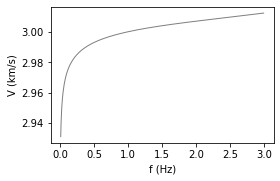

In [53]:
### checkpoint for the exact power-law Q
freq  = np.arange(0.01, 3, 0.005)
omega = 2 * np.pi * freq

### exact phase velocity for power-law Q
Me = cmodulus_powerlawQ(M0, iQ0, alpha, omega0, omega)
vc  = np.sqrt(Me)    
Vexact  = (vc.real**2 + vc.imag**2) / vc.real

############################
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(freq, Vexact, color="gray", lw=1, ls="solid",  \
         label="exact")

plt.xlabel("f (Hz)")
plt.ylabel("V (km/s)")       

plt.show()
plt.close()

### Source wavelet

In [54]:
### the dominant frequency of the source wavelet is idential to the reference frequency
fc = f0

#### time sampling
dt = 1e-2

tmax = 250

n = int(tmax / dt)

omegamax = np.pi / dt

df = 1. / (n*dt)

print("dt = %s" % str(dt))
print("fmax = %s Hz" % str(1/dt))
print("df =%s Hz" % str(df))

t_all = np.arange(0, n) * dt

tdata = ricker_wavelet(fc, t_all)

###### fourier transform ###########
f_all     = (np.arange(0, n) + 1. - n/2.) * df
omega_all = 2.* np.pi * f_all

fdata_normal = fourier_time(tdata)

### remove the alias at zero frequency
### note that after the fourier transform, the data at zero frequency is nonzero and quite large. 
### We need to remove this alias, because the wave amplitude at zero frequency must be zero for a real signal.
index_f0 = int(n/2 -1)
fdata_normal[index_f0] = 0

dt = 0.01
fmax = 100.0 Hz
df =0.004 Hz


### checkpoint to plot source wavelet

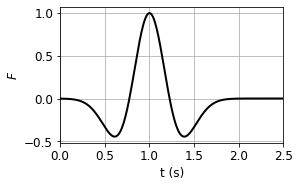

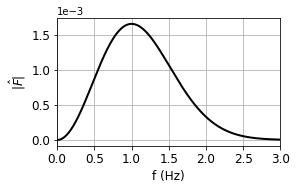

In [55]:
################### Plot source wavelet  #####################
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(t_all, tdata, color='k', lw=2, ls='solid')

plt.grid(True)

plt.xlim(0, 2.5)

font_size = 12

ax.set_xlabel("t (s)", size=font_size)
ax.set_ylabel("$F$", size=font_size)

ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

plt.show()
plt.close()

################### Plot source wavelet spectrum #####################
fig = plt.figure(figsize=(4, 2.35))
ax = fig.add_subplot(1, 1, 1)

plt.plot(f_all, np.abs(fdata_normal), color='k', lw=2, ls='solid')

plt.grid(True)

plt.xlim(0, 3)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

font_size = 12

ax.set_xlabel("f (Hz)", size=font_size)
ax.set_ylabel(r"$|\hat{F}|$", size=font_size)

ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

plt.show()
plt.close()

### Wave propagation at distance r = 300 km

In [56]:
### propagation distance
distance = 300

### nonattenuating media
green_noQ_freq = point_source_wave_nonatten(M0, omega_all, distance)

wf_noQ_freq = np.multiply(fdata_normal, green_noQ_freq)

### The exact power-law Q model
green_PLexact_freq = point_source_wave_atten(cmodulus_powerlawQ, M0, iQ0, alpha, \
                                             omega0, omega_all, distance)
wf_PLexact_freq = np.multiply(fdata_normal, green_PLexact_freq)


### powerlaw-Q 2nd-model
green_PL2nd_freq = point_source_wave_atten(cmodulus_powerlaw_2nd, M0, iQ0, alpha, \
                                                omega0, omega_all, distance)
wf_PL2nd_freq = np.multiply(fdata_normal, green_PL2nd_freq)

### powerlaw-Q 3rd-model
green_PL3rd_freq = point_source_wave_atten(cmodulus_powerlaw_3rd, M0, iQ0, alpha, \
                                           omega0, omega_all, distance)
wf_PL3rd_freq = np.multiply(fdata_normal, green_PL3rd_freq)

### powerlaw-Q 4th-model
green_PL4th_freq = point_source_wave_atten(cmodulus_powerlaw_4th, M0, iQ0, alpha, \
                                                omega0, omega_all, distance)
wf_PL4th_freq = np.multiply(fdata_normal, green_PL4th_freq)

### powerlaw-Q appr 5th-model
green_PL5th_freq = point_source_wave_atten(cmodulus_powerlaw_5th, M0, iQ0, alpha, \
                                                omega0, omega_all, distance)
wf_PL5th_freq = np.multiply(fdata_normal, green_PL5th_freq)


### powerlaw-Q appr 2nd-model
green_PL2nd_appr_freq = point_source_wave_atten(cmodulus_powerlaw_2nd_appr, M0, iQ0, alpha, \
                                                omega0, omega_all, distance)
wf_PL2nd_appr_freq = np.multiply(fdata_normal, green_PL2nd_appr_freq)

### powerlaw-Q appr 3rd-model
green_PL3rd_appr_freq = point_source_wave_atten(cmodulus_powerlaw_3rd_appr, M0, iQ0, alpha, \
                                           omega0, omega_all, distance)
wf_PL3rd_appr_freq = np.multiply(fdata_normal, green_PL3rd_appr_freq)

### powerlaw-Q appr 4th-model
green_PL4th_appr_freq = point_source_wave_atten(cmodulus_powerlaw_4th_appr, M0, iQ0, alpha, \
                                                omega0, omega_all, distance)
wf_PL4th_appr_freq = np.multiply(fdata_normal, green_PL4th_appr_freq)

### powerlaw-Q appr 5th-model
green_PL5th_appr_freq = point_source_wave_atten(cmodulus_powerlaw_5th_appr, M0, iQ0, alpha, \
                                                omega0, omega_all, distance)
wf_PL5th_appr_freq = np.multiply(fdata_normal, green_PL5th_appr_freq)


##### inverse fourier transform ###########
wf_noQ_t = invfourier_freq(wf_noQ_freq)

wf_PLexact_t  = invfourier_freq(wf_PLexact_freq)

wf_PL2nd_t  = invfourier_freq(wf_PL2nd_freq)
wf_PL3rd_t  = invfourier_freq(wf_PL3rd_freq)
wf_PL4th_t  = invfourier_freq(wf_PL4th_freq)
wf_PL5th_t  = invfourier_freq(wf_PL5th_freq)

wf_PL2nd_appr_t  = invfourier_freq(wf_PL2nd_appr_freq)
wf_PL3rd_appr_t  = invfourier_freq(wf_PL3rd_appr_freq)
wf_PL4th_appr_t  = invfourier_freq(wf_PL4th_appr_freq)
wf_PL5th_appr_t  = invfourier_freq(wf_PL5th_appr_freq)

### 2nd-order dissipative model

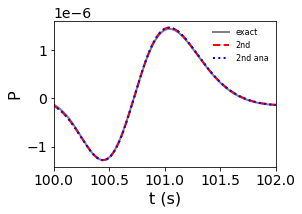

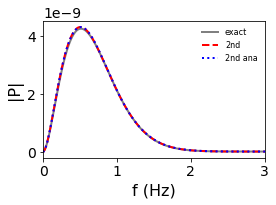

In [57]:
##################  Plot the waveforms for the dissipative models ###############
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(t_all, np.real(wf_noQ_t), color='green', lw=2, ls='solid', \
#         label=r"$1/Q_{0}=0$")
plt.plot(t_all, np.real(wf_PLexact_t), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(t_all, np.real(wf_PL2nd_t), color='red', lw=2, ls='dashed', \
        label="2nd")
plt.plot(t_all, np.real(wf_PL2nd_appr_t), color='blue', lw=2, ls='dotted', \
        label="2nd ana")

ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(100, 102)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("t (s)", size=font_size)
ax.set_ylabel("P", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnP    = "./figs/waveform_2nd_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnP, bbox_inches="tight")

plt.show()
plt.close()

################### Plot the waveform spectrum #####################
fig = plt.figure(figsize=(4, 2.35))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(f_all, np.abs(wf_noQ_freq), color='green', lw=2, ls='solid', \
#         label=r"$Q_{0}=\infty$")
plt.plot(f_all, np.abs(wf_PLexact_freq), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(f_all, np.abs(wf_PL2nd_freq), color='red', lw=2, ls='dashed', \
        label="2nd")
plt.plot(f_all, np.abs(wf_PL2nd_appr_freq), color='blue', lw=2, ls='dotted',\
        label="2nd ana")

ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(0, 3)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("f (Hz)", size=font_size)
ax.set_ylabel("|P|", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnA    = "./figs/amplitude_2nd_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnA, bbox_inches="tight")

plt.show()
plt.close()

### 3rd-order dissipative model

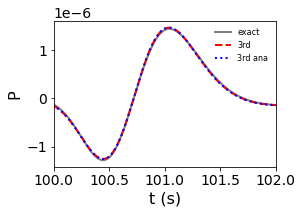

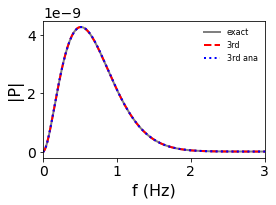

In [58]:
##################  Plot the waveforms for the dissipative models ###############
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(t_all, np.real(wf_noQ_t), color='green', lw=2, ls='solid', \
#         label=r"$1/Q_{0}=0$")
plt.plot(t_all, np.real(wf_PLexact_t), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(t_all, np.real(wf_PL3rd_t), color='red', lw=2, ls='dashed', \
        label="3rd")
plt.plot(t_all, np.real(wf_PL3rd_appr_t), color='blue', lw=2, ls='dotted', \
        label="3rd ana")


ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(100, 102)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("t (s)", size=font_size)
ax.set_ylabel("P", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnP    = "./figs/waveform_3rd_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnP, bbox_inches="tight")

plt.show()
plt.close()

################### Plot the waveform spectrum #####################
fig = plt.figure(figsize=(4, 2.35))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(f_all, np.abs(wf_noQ_freq), color='green', lw=2, ls='solid', \
#         label=r"$Q_{0}=\infty$")
plt.plot(f_all, np.abs(wf_PLexact_freq), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(f_all, np.abs(wf_PL3rd_freq), color='red', lw=2, ls='dashed', \
        label="3rd")
plt.plot(f_all, np.abs(wf_PL3rd_appr_freq), color='blue', lw=2, ls='dotted',\
        label="3rd ana")

ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(0, 3)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("f (Hz)", size=font_size)
ax.set_ylabel("|P|", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnA    = "./figs/amplitude_3rd_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnA, bbox_inches="tight")

plt.show()
plt.close()

### 4th order dissipative model

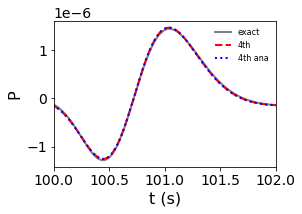

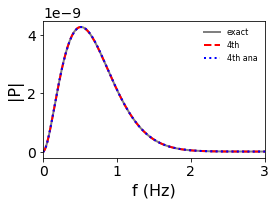

In [59]:
##################  Plot the waveforms for the dissipative models ###############
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(t_all, np.real(wf_noQ_t), color='green', lw=2, ls='solid', \
#         label=r"$1/Q_{0}=0$")
plt.plot(t_all, np.real(wf_PLexact_t), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(t_all, np.real(wf_PL4th_t), color='red', lw=2, ls='dashed', \
        label="4th")
plt.plot(t_all, np.real(wf_PL4th_appr_t), color='blue', lw=2, ls='dotted', \
        label="4th ana")


ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(100, 102)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("t (s)", size=font_size)
ax.set_ylabel("P", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnP    = "./figs/waveform_4th_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnP, bbox_inches="tight")

plt.show()
plt.close()

################### Plot the waveform spectrum #####################
fig = plt.figure(figsize=(4, 2.35))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(f_all, np.abs(wf_noQ_freq), color='green', lw=2, ls='solid', \
#         label=r"$Q_{0}=\infty$")
plt.plot(f_all, np.abs(wf_PLexact_freq), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(f_all, np.abs(wf_PL4th_freq), color='red', lw=2, ls='dashed', \
        label="4th")
plt.plot(f_all, np.abs(wf_PL4th_appr_freq), color='blue', lw=2, ls='dotted',\
        label="4th ana")

ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(0, 3)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("f (Hz)", size=font_size)
ax.set_ylabel("|P|", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnA    = "./figs/amplitude_4th_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnA, bbox_inches="tight")

plt.show()
plt.close()

### 5th order dissipative model

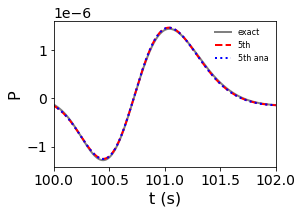

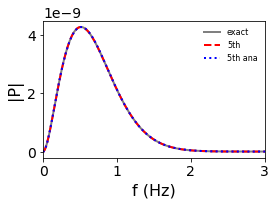

In [60]:
##################  Plot the waveforms for the dissipative models ###############
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(t_all, np.real(wf_noQ_t), color='green', lw=2, ls='solid', \
#         label=r"$1/Q_{0}=0$")
plt.plot(t_all, np.real(wf_PLexact_t), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(t_all, np.real(wf_PL5th_t), color='red', lw=2, ls='dashed', \
        label="5th")
plt.plot(t_all, np.real(wf_PL5th_appr_t), color='blue', lw=2, ls='dotted', \
        label="5th ana")


ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(100, 102)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("t (s)", size=font_size)
ax.set_ylabel("P", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnP    = "./figs/waveform_5th_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnP, bbox_inches="tight")

plt.show()
plt.close()

################### Plot the waveform spectrum #####################
fig = plt.figure(figsize=(4, 2.35))
ax = fig.add_subplot(1, 1, 1)

fig.subplots_adjust(left=.18, bottom=.16, right=.95, top=.97)

# plt.plot(f_all, np.abs(wf_noQ_freq), color='green', lw=2, ls='solid', \
#         label=r"$Q_{0}=\infty$")
plt.plot(f_all, np.abs(wf_PLexact_freq), color='gray', lw=2, ls='solid', \
        label="exact")
plt.plot(f_all, np.abs(wf_PL5th_freq), color='red', lw=2, ls='dashed', \
        label="5th")
plt.plot(f_all, np.abs(wf_PL5th_appr_freq), color='blue', lw=2, ls='dotted',\
        label="5th ana")

ax.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)

# plt.grid(True)

plt.xlim(0, 3)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### set fontsize of labels
font_size = 16
ax.set_xlabel("f (Hz)", size=font_size)
ax.set_ylabel("|P|", size=font_size)

### set fontsize of ticks
tick_size = 14
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

###set fontsize of offset_text
ax.yaxis.offsetText.set_fontsize(tick_size)

fnA    = "./figs/amplitude_5th_Q%s_alpha%s_fc%s.pdf" %(str(Q0), str(alpha), str(f0))
fig.savefig(fnA, bbox_inches="tight")

plt.show()
plt.close()